# Import library

In [5]:
import os
import os, sys
import glob
import re
import datetime
from datetime import datetime, timedelta 
import math, copy, time
from itertools import cycle
from collections import defaultdict

from parse import parse
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

# import torchvision
# import torchvision.transforms as transforms

from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn import svm


from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.set_option("display.max_column", 100)

In [3]:
# Util functions
def size_and_ratio(df, col, dropna=True):
    if pd.__version__ > '1.1':
        sr = df.groupby(col, dropna=dropna).size().sort_values(ascending=False)
    elif dropna:
        sr = df.groupby(col).size().sort_values(ascending=False)
    else:  # dropna == False
        sr = df.fillna('nan').groupby(col).size().sort_values(ascending=False)
    sr_ratio = sr.copy() / sum(sr)
    print("Sum :", sum(sr), sr.shape)
    sr.name = 'size'
    sr_ratio.name = 'ratio'
    return pd.concat([sr, sr_ratio], axis=1)

In [175]:
dir_result = "../mc_scripts/model/train_result/"

all_results = dict()
result_dirs = sorted(os.listdir(dir_result))
display(result_dirs)
for train_name in result_dirs:
    
    if not os.path.isdir(os.path.join(dir_result, train_name)):
        continue
    
    if not 'v12' in train_name:
        continue
        
    df_result = pd.read_csv(os.path.join(dir_result, train_name, "result.csv"))
    print(train_name)
    display(df_result)
    all_results[train_name] = df_result

['.DS_Store',
 'all_manual_20230323_014415',
 'owid_manual_20230321_050601',
 'patient+loc+loc-1+loc-2+loc-3+loc-4+loc-5+loc-6+loc-7_manual_20230323_010929',
 'patient+loc_manual_20230323_002327',
 'patient_manual_20230321_050609',
 'patient_manual_20230322_212408',
 'si3_manual_20230321_050605',
 'v10_patient_testmonthvalrandom_20230327_012748',
 'v10_patient_testmonthvalrandom_20230327_012810',
 'v10_patient_testmonthvalrandom_20230327_013715',
 'v10_patient_testmonthvalrandom_20230327_014846',
 'v10_patient_testmonthvalrandom_20230327_022118',
 'v10_patient_testmonthvalrandom_20230327_023343',
 'v10_patient_testmonthvalrandom_20230327_024558',
 'v10_patient_testmonthvalrandom_20230327_050747',
 'v10_patient_testmonthvalrandom_20230327_052517',
 'v10_patient_testmonthvalrandom_20230327_071354',
 'v10_patient_testmonthvalrandom_20230327_084910',
 'v10_patient_testmonthvalrandom_20230327_122900',
 'v11_all_testmonthvalrandom_20230327_180822_2022-03',
 'v11_all_testmonthvalrandom_202303

v12_all_testmonthvalmonth_20230409_233913_test2022-03_val2022-02


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.814730,0.807111,0.815724,0.822610,0.824736,0.816982,5.714005e-03
1,XGBoost,0.806862,0.806862,0.806862,0.806862,0.806862,0.806862,1.110223e-16
2,LGBM,0.753670,0.753670,0.753670,0.753670,0.753670,0.753670,0.000000e+00
3,TabNet,0.557580,0.442585,0.355408,0.606015,0.558014,0.503920,8.371262e-02


v12_all_testmonthvalmonth_20230409_233940_test2022-04_val2022-03


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.896917,0.895778,0.897901,0.896794,0.897625,0.897003,0.000676
1,XGBoost,0.720680,0.720680,0.720680,0.720680,0.720680,0.720680,0.000000
2,LGBM,0.856246,0.856246,0.856246,0.856246,0.856246,0.856246,0.000000
3,TabNet,0.615321,0.473130,0.371254,0.498219,0.541369,0.499859,0.073384


v12_all_testmonthvalmonth_20230409_234207_test2022-05_val2022-04


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.802829,0.797840,0.797853,0.791113,0.801489,0.798225,0.003713
1,XGBoost,0.761836,0.761836,0.761836,0.761836,0.761836,0.761836,0.000000
2,LGBM,0.796301,0.796301,0.796301,0.796301,0.796301,0.796301,0.000000
3,TabNet,0.719151,0.766672,0.742079,0.765226,0.770699,0.752765,0.017863


v12_all_testmonthvalmonth_20230410_000016_test2022-06_val2022-05


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.806261,0.815180,0.804202,0.800343,0.814494,0.808096,0.005319
1,XGBoost,0.764022,0.764022,0.764022,0.764022,0.764022,0.764022,0.000000
2,LGBM,0.798885,0.798885,0.798885,0.798885,0.798885,0.798885,0.000000
3,TabNet,0.597384,0.736792,0.726458,0.663508,0.751329,0.695094,0.052329


v12_all_testmonthvalmonth_20230410_003035_test2022-07_val2022-06


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.838569,0.825352,0.833890,0.827650,0.837146,0.832521,4.742918e-03
1,XGBoost,0.833466,0.833466,0.833466,0.833466,0.833466,0.833466,4.532467e-17
2,LGBM,0.850337,0.850337,0.850337,0.850337,0.850337,0.850337,4.532467e-17
3,TabNet,0.784412,0.744363,0.827965,0.815692,0.756787,0.785844,2.953004e-02


v12_all_testmonthvalmonth_20230410_005328_test2022-08_val2022-07


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.763048,0.764877,0.762691,0.760642,0.762608,0.762773,0.00123
1,XGBoost,0.768140,0.768140,0.768140,0.768140,0.768140,0.768140,0.00000
2,LGBM,0.792107,0.792107,0.792107,0.792107,0.792107,0.792107,0.00000


v12_patient_testmonthvalmonth_20230409_233913_test2022-03_val2022-02


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.835584,0.836962,0.832525,0.836475,0.836525,0.835614,1.468022e-03
1,XGBoost,0.776877,0.776877,0.776877,0.776877,0.776877,0.776877,1.110223e-16
2,LGBM,0.747755,0.747755,0.747755,0.747755,0.747755,0.747755,0.000000e+00
3,TabNet,0.488531,0.590363,0.419127,0.732859,0.781013,0.602379,1.262418e-01


v12_patient_testmonthvalmonth_20230409_233934_test2022-04_val2022-03


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.867363,0.867499,0.867827,0.867721,0.868394,0.867761,0.000325
1,XGBoost,0.829915,0.829915,0.829915,0.829915,0.829915,0.829915,0.000000
2,LGBM,0.837509,0.837509,0.837509,0.837509,0.837509,0.837509,0.000000
3,TabNet,0.507875,0.593993,0.413360,0.735524,0.795008,0.609152,0.128669


v12_patient_testmonthvalmonth_20230409_234102_test2022-05_val2022-04


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.774129,0.773187,0.772722,0.771687,0.772669,0.772879,0.000724
1,XGBoost,0.782641,0.782641,0.782641,0.782641,0.782641,0.782641,0.000000
2,LGBM,0.781453,0.781453,0.781453,0.781453,0.781453,0.781453,0.000000
3,TabNet,0.767415,0.771973,0.775204,0.785858,0.772192,0.774528,0.005648


v12_patient_testmonthvalmonth_20230409_235727_test2022-06_val2022-05


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.812436,0.812693,0.818782,0.809262,0.811578,0.812950,2.881698e-03
1,XGBoost,0.829417,0.829417,0.829417,0.829417,0.829417,0.829417,0.000000e+00
2,LGBM,0.838808,0.838808,0.838808,0.838808,0.838808,0.838808,1.110223e-16
3,TabNet,0.817753,0.845840,0.831046,0.844597,0.846998,0.837247,1.033942e-02


v12_patient_testmonthvalmonth_20230410_002437_test2022-07_val2022-06


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.839404,0.839486,0.837078,0.838610,0.839185,0.838753,8.138576e-04
1,XGBoost,0.839390,0.839390,0.839390,0.839390,0.839390,0.839390,0.000000e+00
2,LGBM,0.836558,0.836558,0.836558,0.836558,0.836558,0.836558,1.110223e-16
3,TabNet,0.826597,0.823614,0.802050,0.833178,0.829032,0.822894,9.934446e-03


v12_patient_testmonthvalmonth_20230410_004259_test2022-08_val2022-07


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.788180,0.789121,0.788385,0.788104,0.788923,0.788542,3.716004e-04
1,XGBoost,0.789421,0.789421,0.789421,0.789421,0.789421,0.789421,0.000000e+00
2,LGBM,0.800436,0.800436,0.800436,0.800436,0.800436,0.800436,4.532467e-17
3,TabNet,0.797124,0.787865,0.796642,0.780105,0.790563,0.790460,5.724158e-03


v12_patient_testmonthvalmonth_20230410_010505_test2022-09_val2022-08


,Unnamed: 0,0,1,2,3,4,mean,std
0,LR,0.789887,0.790075,0.790287,0.789322,0.790311,0.789976,3.303165e-04
1,XGBoost,0.814422,0.814422,0.814422,0.814422,0.814422,0.814422,1.110223e-16


In [176]:
df_result_all = pd.DataFrame()

for train_name, df_result in all_results.items():
    df_result = df_result.rename(columns={'Unnamed: 0': 'structure'})
    df_result['train_name'] = train_name
    df_result_all = df_result_all.append(df_result)
    print(train_name, df_result.shape, df_result_all.shape)

df_result_all

v12_all_testmonthvalmonth_20230409_233913_test2022-03_val2022-02 (4, 9) (4, 9)
v12_all_testmonthvalmonth_20230409_233940_test2022-04_val2022-03 (4, 9) (8, 9)
v12_all_testmonthvalmonth_20230409_234207_test2022-05_val2022-04 (4, 9) (12, 9)
v12_all_testmonthvalmonth_20230410_000016_test2022-06_val2022-05 (4, 9) (16, 9)
v12_all_testmonthvalmonth_20230410_003035_test2022-07_val2022-06 (4, 9) (20, 9)
v12_all_testmonthvalmonth_20230410_005328_test2022-08_val2022-07 (3, 9) (23, 9)
v12_patient_testmonthvalmonth_20230409_233913_test2022-03_val2022-02 (4, 9) (27, 9)
v12_patient_testmonthvalmonth_20230409_233934_test2022-04_val2022-03 (4, 9) (31, 9)
v12_patient_testmonthvalmonth_20230409_234102_test2022-05_val2022-04 (4, 9) (35, 9)
v12_patient_testmonthvalmonth_20230409_235727_test2022-06_val2022-05 (4, 9) (39, 9)
v12_patient_testmonthvalmonth_20230410_002437_test2022-07_val2022-06 (4, 9) (43, 9)
v12_patient_testmonthvalmonth_20230410_004259_test2022-08_val2022-07 (4, 9) (47, 9)
v12_patient_testmo

/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_35113/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result_all = df_result_all.append(df_result)
/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_35113/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result_all = df_result_all.append(df_result)
/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_35113/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result_all = df_result_all.append(df_result)
/var/folders/4_/8b2y3j_j3dxdsynsnnwt5drc0000gn/T/ipykernel_35113/2769481730.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

,structure,0,1,2,3,4,mean,std,train_name
0,LR,0.814730,0.807111,0.815724,0.822610,0.824736,0.816982,5.714005e-03,v12_all_testmonthvalmonth_20230409_233913_test...
1,XGBoost,0.806862,0.806862,0.806862,0.806862,0.806862,0.806862,1.110223e-16,v12_all_testmonthvalmonth_20230409_233913_test...
2,LGBM,0.753670,0.753670,0.753670,0.753670,0.753670,0.753670,0.000000e+00,v12_all_testmonthvalmonth_20230409_233913_test...
3,TabNet,0.557580,0.442585,0.355408,0.606015,0.558014,0.503920,8.371262e-02,v12_all_testmonthvalmonth_20230409_233913_test...
0,LR,0.896917,0.895778,0.897901,0.896794,0.897625,0.897003,6.763973e-04,v12_all_testmonthvalmonth_20230409_233940_test...
1,XGBoost,0.720680,0.720680,0.720680,0.720680,0.720680,0.720680,0.000000e+00,v12_all_testmonthvalmonth_20230409_233940_test...
2,LGBM,0.856246,0.856246,0.856246,0.856246,0.856246,0.856246,0.000000e+00,v12_all_testmonthvalmonth_20230409_233940_test...
3,TabNet,0.615321,0.473130,0.371254,0.498219,0.541369,0.499859,7.338353e-02,v12_all_testmonthvalmonth_20230409_233940_test...
0,LR,0.802829,0.797840,0.797853,0.791113,0.801489,0.798225,3.713015e-03,v12_all_testmonthvalmonth_20230409_234207_test...
1,XGBoost,0.761836,0.761836,0.761836,0.761836,0.761836,0.761836,0.000000e+00,v12_all_testmonthvalmonth_20230409_234207_test...


In [177]:
df_result_all['split'] = df_result_all['train_name'].apply(lambda x : x.split("_")[2])
df_result_all['features'] = df_result_all['train_name'].apply(lambda x : x.split("_")[1])
df_result_all['year_month'] = df_result_all['train_name'].apply(lambda x : x.split("_")[-2] if not x.split("_")[2] == 'manual' else None)
df_result_all

,structure,0,1,2,3,4,mean,std,train_name,split,features,year_month
0,LR,0.814730,0.807111,0.815724,0.822610,0.824736,0.816982,5.714005e-03,v12_all_testmonthvalmonth_20230409_233913_test...,testmonthvalmonth,all,test2022-03
1,XGBoost,0.806862,0.806862,0.806862,0.806862,0.806862,0.806862,1.110223e-16,v12_all_testmonthvalmonth_20230409_233913_test...,testmonthvalmonth,all,test2022-03
2,LGBM,0.753670,0.753670,0.753670,0.753670,0.753670,0.753670,0.000000e+00,v12_all_testmonthvalmonth_20230409_233913_test...,testmonthvalmonth,all,test2022-03
3,TabNet,0.557580,0.442585,0.355408,0.606015,0.558014,0.503920,8.371262e-02,v12_all_testmonthvalmonth_20230409_233913_test...,testmonthvalmonth,all,test2022-03
0,LR,0.896917,0.895778,0.897901,0.896794,0.897625,0.897003,6.763973e-04,v12_all_testmonthvalmonth_20230409_233940_test...,testmonthvalmonth,all,test2022-04
1,XGBoost,0.720680,0.720680,0.720680,0.720680,0.720680,0.720680,0.000000e+00,v12_all_testmonthvalmonth_20230409_233940_test...,testmonthvalmonth,all,test2022-04
2,LGBM,0.856246,0.856246,0.856246,0.856246,0.856246,0.856246,0.000000e+00,v12_all_testmonthvalmonth_20230409_233940_test...,testmonthvalmonth,all,test2022-04
3,TabNet,0.615321,0.473130,0.371254,0.498219,0.541369,0.499859,7.338353e-02,v12_all_testmonthvalmonth_20230409_233940_test...,testmonthvalmonth,all,test2022-04
0,LR,0.802829,0.797840,0.797853,0.791113,0.801489,0.798225,3.713015e-03,v12_all_testmonthvalmonth_20230409_234207_test...,testmonthvalmonth,all,test2022-05
1,XGBoost,0.761836,0.761836,0.761836,0.761836,0.761836,0.761836,0.000000e+00,v12_all_testmonthvalmonth_20230409_234207_test...,testmonthvalmonth,all,test2022-05


In [178]:
df_result_all[df_result_all['structure'] == 'LR']

,structure,0,1,2,3,4,mean,std,train_name,split,features,year_month
0,LR,0.814730,0.807111,0.815724,0.822610,0.824736,0.816982,0.005714,v12_all_testmonthvalmonth_20230409_233913_test...,testmonthvalmonth,all,test2022-03
0,LR,0.896917,0.895778,0.897901,0.896794,0.897625,0.897003,0.000676,v12_all_testmonthvalmonth_20230409_233940_test...,testmonthvalmonth,all,test2022-04
0,LR,0.802829,0.797840,0.797853,0.791113,0.801489,0.798225,0.003713,v12_all_testmonthvalmonth_20230409_234207_test...,testmonthvalmonth,all,test2022-05
0,LR,0.806261,0.815180,0.804202,0.800343,0.814494,0.808096,0.005319,v12_all_testmonthvalmonth_20230410_000016_test...,testmonthvalmonth,all,test2022-06
0,LR,0.838569,0.825352,0.833890,0.827650,0.837146,0.832521,0.004743,v12_all_testmonthvalmonth_20230410_003035_test...,testmonthvalmonth,all,test2022-07
0,LR,0.763048,0.764877,0.762691,0.760642,0.762608,0.762773,0.001230,v12_all_testmonthvalmonth_20230410_005328_test...,testmonthvalmonth,all,test2022-08
0,LR,0.835584,0.836962,0.832525,0.836475,0.836525,0.835614,0.001468,v12_patient_testmonthvalmonth_20230409_233913_...,testmonthvalmonth,patient,test2022-03
0,LR,0.867363,0.867499,0.867827,0.867721,0.868394,0.867761,0.000325,v12_patient_testmonthvalmonth_20230409_233934_...,testmonthvalmonth,patient,test2022-04
0,LR,0.774129,0.773187,0.772722,0.771687,0.772669,0.772879,0.000724,v12_patient_testmonthvalmonth_20230409_234102_...,testmonthvalmonth,patient,test2022-05
0,LR,0.812436,0.812693,0.818782,0.809262,0.811578,0.812950,0.002882,v12_patient_testmonthvalmonth_20230409_235727_...,testmonthvalmonth,patient,test2022-06


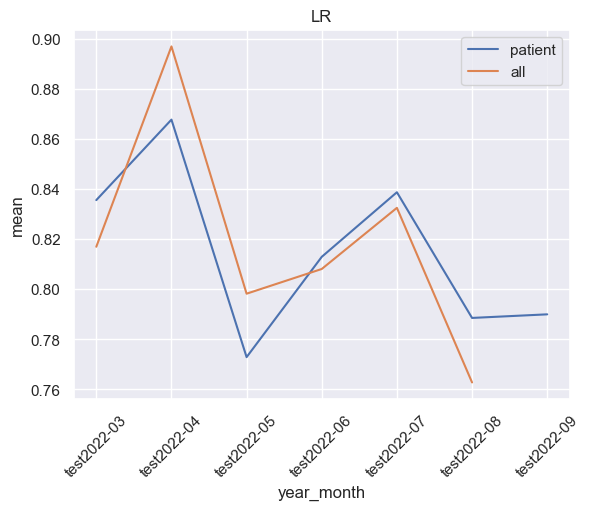

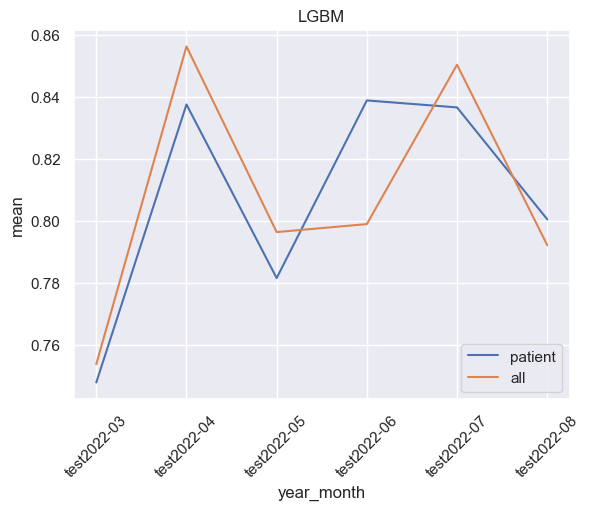

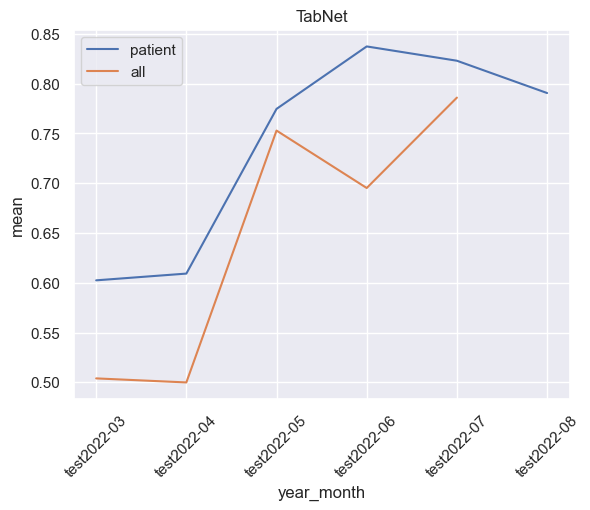

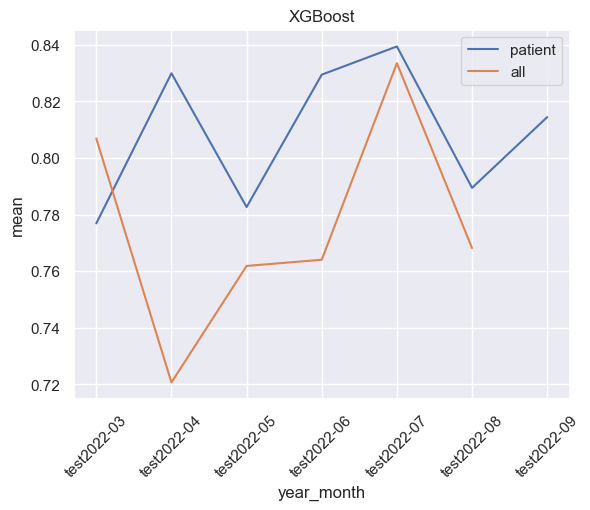

In [179]:
def plot_patient_vs_all(df_result_all, structure):
    df_lr = df_result_all[df_result_all['structure'] == structure]
    df_lr_patient = df_lr[df_lr['features'] == 'patient']
    df_lr_all = df_lr[df_lr['features'] == 'all']
    sns.lineplot(data=df_lr_patient.reset_index(drop=True), x='year_month', y='mean', label='patient')
    sns.lineplot(data=df_lr_all.reset_index(drop=True), x='year_month', y='mean', label='all')
    plt.title(structure)
    plt.xticks(rotation=45)
    plt.show()
    
plot_patient_vs_all(df_result_all, 'LR')
plot_patient_vs_all(df_result_all, 'LGBM')
plot_patient_vs_all(df_result_all, 'TabNet')
plot_patient_vs_all(df_result_all, 'XGBoost')

In [180]:
df_result_all

,structure,0,1,2,3,4,mean,std,train_name,split,features,year_month
0,LR,0.814730,0.807111,0.815724,0.822610,0.824736,0.816982,5.714005e-03,v12_all_testmonthvalmonth_20230409_233913_test...,testmonthvalmonth,all,test2022-03
1,XGBoost,0.806862,0.806862,0.806862,0.806862,0.806862,0.806862,1.110223e-16,v12_all_testmonthvalmonth_20230409_233913_test...,testmonthvalmonth,all,test2022-03
2,LGBM,0.753670,0.753670,0.753670,0.753670,0.753670,0.753670,0.000000e+00,v12_all_testmonthvalmonth_20230409_233913_test...,testmonthvalmonth,all,test2022-03
3,TabNet,0.557580,0.442585,0.355408,0.606015,0.558014,0.503920,8.371262e-02,v12_all_testmonthvalmonth_20230409_233913_test...,testmonthvalmonth,all,test2022-03
0,LR,0.896917,0.895778,0.897901,0.896794,0.897625,0.897003,6.763973e-04,v12_all_testmonthvalmonth_20230409_233940_test...,testmonthvalmonth,all,test2022-04
1,XGBoost,0.720680,0.720680,0.720680,0.720680,0.720680,0.720680,0.000000e+00,v12_all_testmonthvalmonth_20230409_233940_test...,testmonthvalmonth,all,test2022-04
2,LGBM,0.856246,0.856246,0.856246,0.856246,0.856246,0.856246,0.000000e+00,v12_all_testmonthvalmonth_20230409_233940_test...,testmonthvalmonth,all,test2022-04
3,TabNet,0.615321,0.473130,0.371254,0.498219,0.541369,0.499859,7.338353e-02,v12_all_testmonthvalmonth_20230409_233940_test...,testmonthvalmonth,all,test2022-04
0,LR,0.802829,0.797840,0.797853,0.791113,0.801489,0.798225,3.713015e-03,v12_all_testmonthvalmonth_20230409_234207_test...,testmonthvalmonth,all,test2022-05
1,XGBoost,0.761836,0.761836,0.761836,0.761836,0.761836,0.761836,0.000000e+00,v12_all_testmonthvalmonth_20230409_234207_test...,testmonthvalmonth,all,test2022-05


In [181]:

def reformat_target_table(df_result_all):
    # Reformat table
    df = df_result_all.copy()
    dfs = []
    for i in range(len(df)):
        row = df.iloc[i]
        row_dict = {'structure': row['structure'], 'mean': row['mean'], 'std': row['std'], 'train_name': row['train_name'], 'split': row['split'], 'features': row['features'], 'year_month': row['year_month']}
        for j in range(5):
            row_dict['fold'] = j
            row_dict['score'] = row[str(j)]
            dfs.append(pd.DataFrame([row_dict]))

    # concatenate the list of dataframes into the regularized table
    df_new = pd.concat(dfs, ignore_index=True)

    # print the regularized tab
    # print the regularized table
    return df_new[['structure', 'year_month', 'fold', 'split', 'features', 'score', 'train_name']]
df_result_all_new = reformat_target_table(df_result_all)
df_result_all_new

,structure,year_month,fold,split,features,score,train_name
0,LR,test2022-03,0,testmonthvalmonth,all,0.814730,v12_all_testmonthvalmonth_20230409_233913_test...
1,LR,test2022-03,1,testmonthvalmonth,all,0.807111,v12_all_testmonthvalmonth_20230409_233913_test...
2,LR,test2022-03,2,testmonthvalmonth,all,0.815724,v12_all_testmonthvalmonth_20230409_233913_test...
3,LR,test2022-03,3,testmonthvalmonth,all,0.822610,v12_all_testmonthvalmonth_20230409_233913_test...
4,LR,test2022-03,4,testmonthvalmonth,all,0.824736,v12_all_testmonthvalmonth_20230409_233913_test...
...,...,...,...,...,...,...,...
240,XGBoost,test2022-09,0,testmonthvalmonth,patient,0.814422,v12_patient_testmonthvalmonth_20230410_010505_...
241,XGBoost,test2022-09,1,testmonthvalmonth,patient,0.814422,v12_patient_testmonthvalmonth_20230410_010505_...
242,XGBoost,test2022-09,2,testmonthvalmonth,patient,0.814422,v12_patient_testmonthvalmonth_20230410_010505_...
243,XGBoost,test2022-09,3,testmonthvalmonth,patient,0.814422,v12_patient_testmonthvalmonth_20230410_010505_...


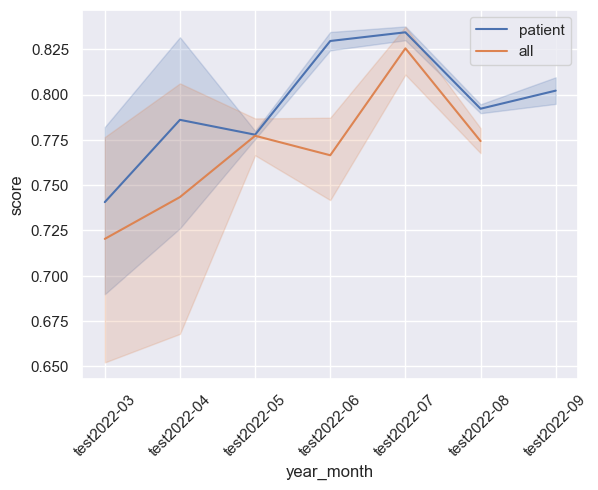

In [182]:
sns.lineplot(data=df_result_all_new[df_result_all_new['features'] == 'patient'], x='year_month', y='score', label='patient')
sns.lineplot(data=df_result_all_new[df_result_all_new['features'] == 'all'], x='year_month', y='score', label='all')
plt.xticks(rotation=45)
plt.show()

In [124]:
df_result_all_new[df_result_all_new['year_month'] == '2022-04']

,structure,year_month,fold,split,features,score,train_name


In [126]:

# df_plot1 = reformat_target_table(df_result_all, 'LGBM', 'patient')
# sns.lineplot(data=df_plot1, x='year_month', y='score')
# df_plot2 = reformat_target_table(df_result_all, 'LGBM', 'all')
# sns.lineplot(data=df_plot2, x='year_month', y='score')
# plt.ylim(0.5, 0.95)
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

# T-test

In [20]:
for key, values in v3_12_performance.items():

    v3_12_values = values
    v3_1_values = v3_1_performance[key]
    
    # Perform the paired t-test
    stat, p = ttest_rel(v3_12_values, v3_1_values)

    # Print the results
    print(f"{key}, Paired t-test:")
    print(f" - Statistic: {stat:.4f}")
    print(f" - p-value: {p:.4f}")
    print()

RL, Paired t-test:
 - Statistic: 5.9632
 - p-value: 0.0010

XGBoost, Paired t-test:
 - Statistic: 5.5913
 - p-value: 0.0014

LGBM, Paired t-test:
 - Statistic: 5.5061
 - p-value: 0.0015

TabNet, Paired t-test:
 - Statistic: 3.9345
 - p-value: 0.0077



In [3]:
# Define the dictionary of values
RL_values = {0: 0.838625043318763, 1: 0.8381056968241842, 2: 0.838121731946367, 3: 0.8381724699449158, 4: 0.8386626181573107}

# Assign the values to a list variable
RL_list = [RL_values[i] for i in range(len(RL_values))]

# Print the list variable
print(RL_list)

[0.838625043318763, 0.8381056968241842, 0.838121731946367, 0.8381724699449158, 0.8386626181573107]


In [4]:
from scipy.stats import ttest_rel

# Define the RL performance in the first table and the second table as lists
v3_12_RL = [0.8418617324532305, 0.8415487608796515, 0.8416251735299258, 0.8412595824666369, 0.8419745211855217]
v3_1_RL = [0.838625043318763, 0.8381056968241842, 0.838121731946367, 0.8381724699449158, 0.8386626181573107]

# Perform the paired t-test
stat, p = ttest_rel(table1_RL, table2_RL)

# Print the results
print("Paired t-test:")
print(f"Statistic: {stat:.4f}")
print(f"p-value: {p:.4f}")

Paired t-test:
Statistic: 6.9994
p-value: 0.0022
